In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

from sklearn.preprocessing import MinMaxScaler

HISTORY_LEN = 60

Load stock data

In [5]:
df = pd.read_csv(r'datasets\NSE-Tata.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


Convert string date to Datetime with specifying input date format

In [6]:
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")

First, set the dataframe index to the date feature, next sort it chronologically. Then, let's look at the data itself

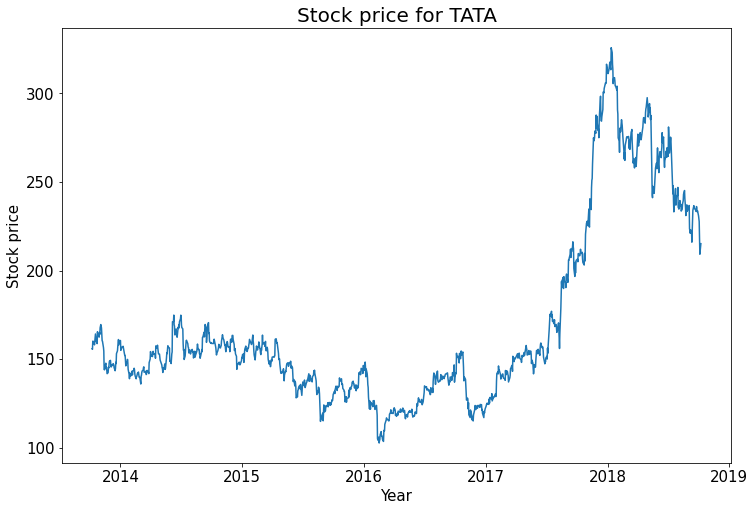

In [113]:
plt.figure(figsize=(12, 8))
df.index = df['Date']
data = df.sort_index(ascending=True, axis=0)
plt.plot(df.Close, label='Close Price History')
plt.ylabel('Stock price', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Stock price for TATA', fontsize=20)
plt.show()

To build our price prediction model, we will try with the closing prices from each day. Let's pull out Close and Date feature out of our data

In [29]:
dataset = pd.DataFrame(index=range(0, df.shape[0]), columns=['Date', 'Close'], data = data[['Date', 'Close']].values)
dataset.index = dataset.Date
dataset.drop("Date", axis=1, inplace=True)

let's split our data into train and val. The ratio of datasets will be 4:1

In [69]:
split = int(0.8 * final_dataset.shape[0])
train_data, test_data = dataset.values[:split], dataset.values[split:]

Neural networks prefer normalized data to 0-1 range, optionally standardized data. We have quite big values, which can really affect the learnign as the losses can be significant (we will use MSE). Let's use MinMaxScaler to transform them to 0-1

Fit and transform the model on train data

In [70]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_data)

We will generate sequence data, where each training observation will consist of 60 previous close prices, and 1 future price. The model, based on previous 60 prices, needs to predict the next price as close as possible to the next real value

In [71]:
def generate_sequence_data(data, history_len):
    x, y = [], []
    for i in range(history_len, len(data)):
        x.append(data[i-history_len:i, 0])
        y.append(data[i, 0])
    x, y = np.array(x), np.array(y)
    return x, y

Use the function and add one dimension more

In [97]:
x_train, y_train = generate_sequence_data(data=scaled_data, history_len=HISTORY_LEN)
x_train = np.reshape(x_train, (*x_train.shape, 1))

We will use quite a simply model, which consists almost entirely from two stacked LSTM layers

In [92]:
def simple_lstm(lstm_input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=lstm_input_shape))

    model.add(LSTM(units=50))
    model.add(Dense(1))
    return model

In [94]:
model = simple_lstm(lstm_input_shape=x_train.shape[1:])

Compile and fit to train data, disregard validation

In [95]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

928/928 - 4s - loss: 0.0040


Let's create test data - we will take last 60 closing prices from trian data to complete predictions for our test data

In [76]:
inputs_data=np.vstack([train_data[-HISTORY_LEN:], test_data])
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

Again, generate sequence data (this time for test), but ignore labels

In [101]:
X_test, _ = generate_sequence_data(data=inputs_data, history_len=HISTORY_LEN)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

Now we use model for prediction, and inverse transform to obtain original values

In [80]:
predicted_closing_price=model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

Plot Prediction versus Ground Truth

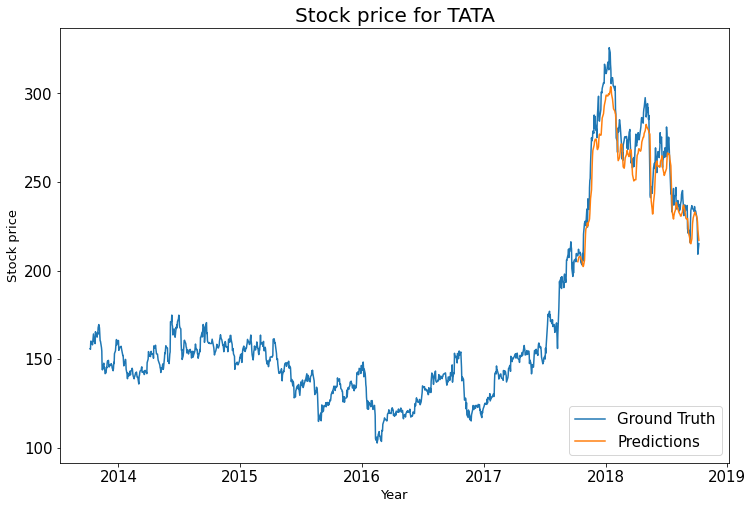

In [114]:
valid_data=dataset[split:]
valid_data['Predictions']=predicted_closing_price
plt.plot(dataset["Close"], label='Ground Truth')
plt.plot(valid_data["Predictions"], label='Predictions')
plt.ylabel('Stock price', fontsize=13)
plt.xlabel('Year', fontsize=13)
plt.tick_params(labelsize=15)
plt.title('Stock price for TATA', fontsize=20)
plt.legend(loc='lower right', fontsize=15)
plt.show()

Save the model for later use

In [102]:
model.save("saved_lstm_model.h5")